In [1]:
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt; import seaborn as sns

- Goal is to address some **Estimand** -- a scientific question
  - i.e. metaphorical Cake we'd like to create
- We use an **Estimator**, which is a set of instructions to organnize code and data to create an estimate of the estimand
  - metaphorical recipe
- The resulting **Estimate** may or may not be the original Estimand you were aiming for. Many things can cause this
  - **bad recipe (e.g. estimator design or confounds -- the focus of this lecture)**
    - the right recipe will defend against confounds
  - bad execution of recipe (e.g. buggy code or interpretation)
  - bad data

### **Confounds**
* Statistical recipes (ESTIMATORS) must fight against confounding
- Some feature of the data (sample) that misleads us, when youre confounded youre confused
- confounds are diverse

# The Periodic Table of Confounds
- The Fork: $X \leftarrow Z \rightarrow Y$
- The Pipe: $X \rightarrow Z \rightarrow Y$
- The Collider: $X \rightarrow Z \leftarrow Y$
- The Descendant: $X \rightarrow Z \rightarrow Y$, $Z \rightarrow A$

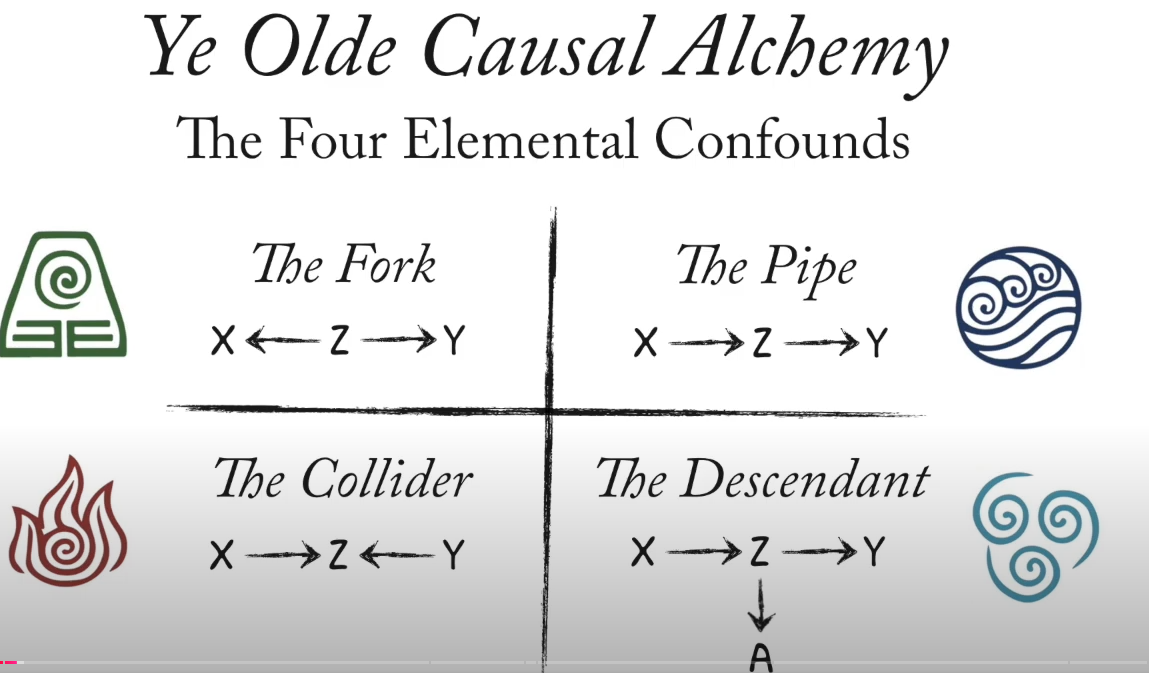

#### THE FORK
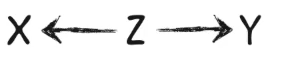
* Z is a common cause of X and Y. There may be more causes of X and Y but Z is a common one.
* X and Y will be associated **because** they share Z, the common cause
* And so, once **stratified** by Z, there is no relationship between X and Y

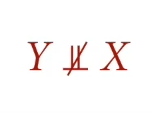
* Y is **NOT INDEPENDENT** OF X
* If you know something about Y or X you know something about the other one

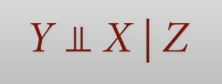
* Y is **INDEPENDENT** of X given Z

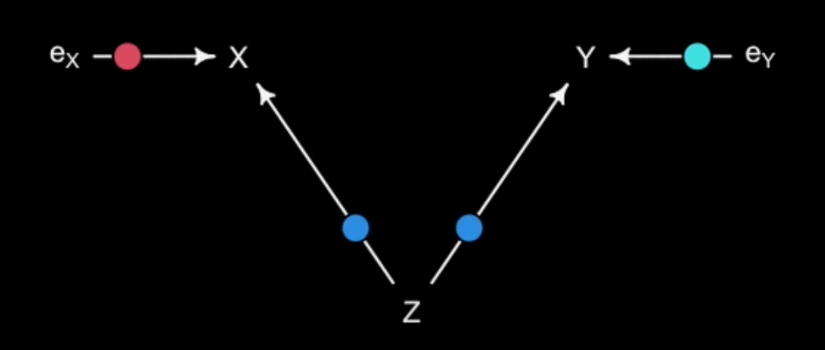
* If Z was the only influence of X and Y, they would be clones of each other
* We have ex and ey, the error terms
* When writing a gen simulation for this **DAG** we have to simulate this

#### Discrete Fork

In [2]:
# Discrete Fork
np.random.seed(321)
n_samples = 1000
Z = stats.bernoulli.rvs(p=0.5, size=n_samples)
p_star = Z * 0.9 + (1 - Z) * 0.1
X = stats.bernoulli.rvs(p=p_star)
Y = stats.bernoulli.rvs(p=p_star)

In [3]:
Z[0:50]

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1], dtype=int64)

In [4]:
p_star[0:5]

array([0.9, 0.1, 0.9, 0.1, 0.9])

In [5]:
X[0:50]

array([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1], dtype=int64)

In [6]:
df = pd.DataFrame(X, columns=["X"])
df = pd.concat([df, pd.DataFrame(Y, columns=["Y"]), pd.DataFrame(Z, columns=["Z"])], axis=1)

In [7]:
df.corr()

,X,Y,Z
X,1.000000,0.626321,0.796219
Y,0.626321,1.000000,0.794016
Z,0.796219,0.794016,1.000000


* We want to grab correlation of X and Y where Z = 0 and where Z = 1

In [8]:
filt = df["Z"] == 0
df_Z_0 = df[filt]
df_Z_1 = df[~filt]

In [9]:
df_Z_0.corr()

,X,Y,Z
X,1.000000,-0.017261,NaN
Y,-0.017261,1.000000,NaN
Z,NaN,NaN,NaN


In [10]:
df_Z_1.corr()

,X,Y,Z
X,1.000000,-0.014927,NaN
Y,-0.014927,1.000000,NaN
Z,NaN,NaN,NaN


* No correlation of X and Y within each level of Z
* We cancelled out Z's influence by looking at each level of Z

#### Continous Fork
* Same basic idea

In [11]:
np.random.seed(1234)
n_samples = 400

Z = stats.bernoulli.rvs(p=.5, size=n_samples)

mu_star = 2 * Z - 1
X = stats.norm.rvs(loc=mu_star, size=n_samples)
Y = stats.norm.rvs(loc=mu_star, size=n_samples)

# Put simulated data into dataframe for statsmodels API
fork_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

In [12]:
fork_data

,Z,X,Y
0,0.0,-0.004007,-0.704369
1,1.0,1.955558,3.079844
2,0.0,-0.286159,-2.842433
3,1.0,1.133371,0.488834
4,1.0,0.192962,0.419065
...,...,...,...
395,1.0,1.363210,0.289586
396,0.0,-2.813277,-1.852559
397,1.0,0.802089,3.710362
398,0.0,-0.567125,-0.969049


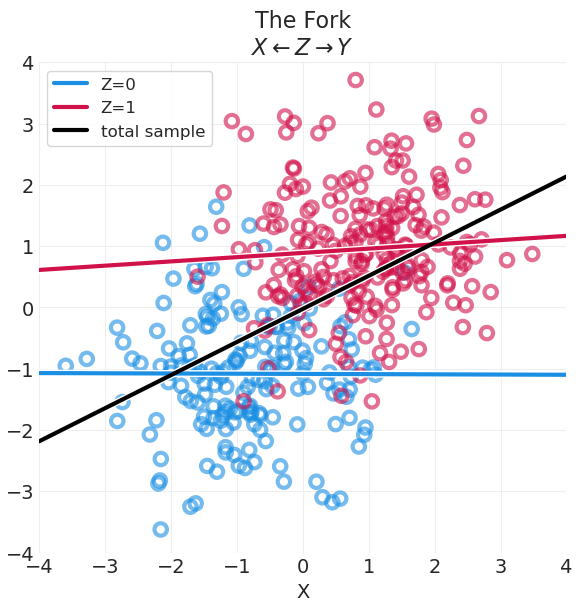
* there are 3 regression lines
* black line is if we ignore the values of 0 there is a clear association
* BUT on each level of 0 knowing X doesnt tell us anything about the value of Y

Now we will do a data analysis example and see why we care about this
* Because just having a scatterplot doesnt tell us whats going on
* but when we have a causal model that implicates a fork in generating the scatterplot, that leads us to design estimators of certain kind, which helps us understand whats happening

In [13]:
WAFFLEHOUSE_DIVORCE = utils.load_data("WaffleDivorce")
df = WAFFLEHOUSE_DIVORCE.head()
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


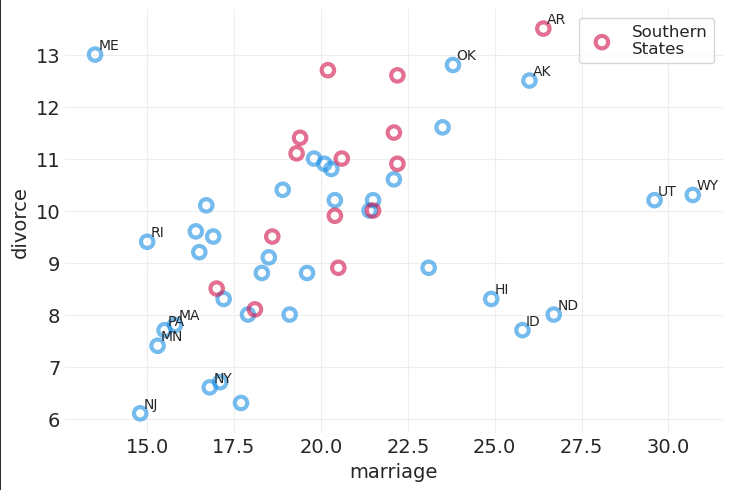

#### (1) ESTIMAND:
* Causal effect of marriage rate on divorce rate

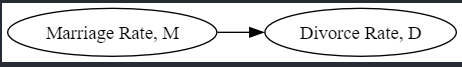

* There is also another potential predictor of divorce rate, Age

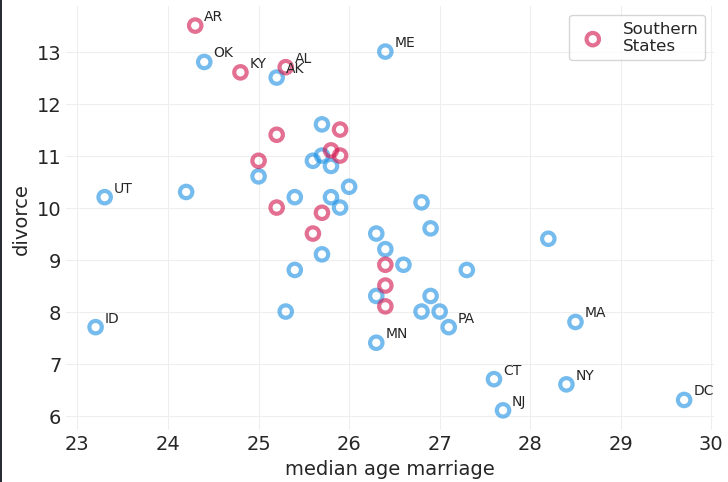

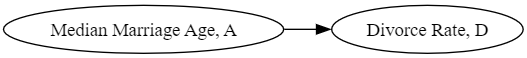

#### (2) Scientific Model
Putting all 3 vars together, What is going on?
* The age of marriage is a **common cause**, its a **fork** of both marriage rate and divorce rate
* Is the association between marriage rate and divorce rate solely a result of the fork? (the common cause, Age of marriage)?

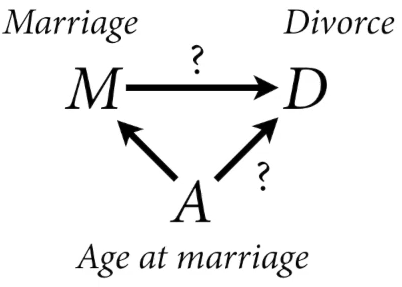


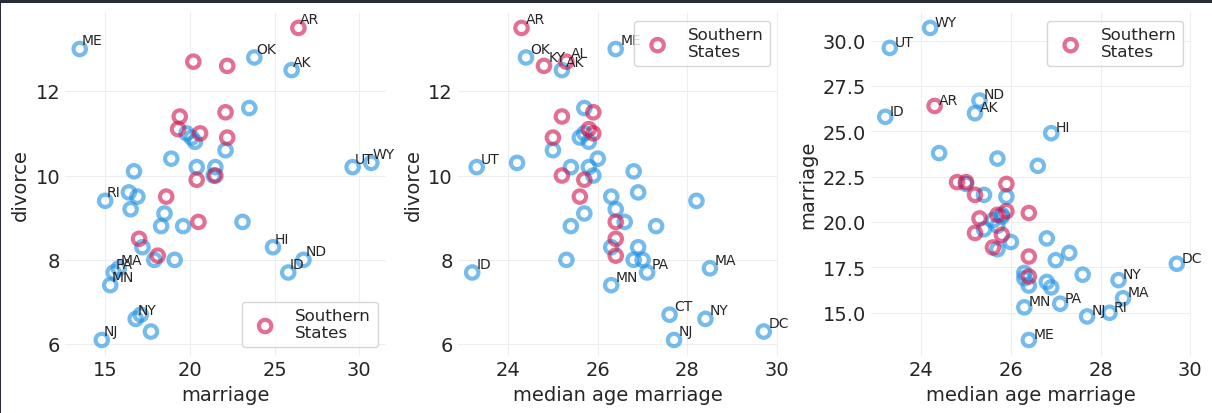

Now we want to develop an estimator to answer this question
* In order to estimate the causal effect of **M** on **D** we need to break the fork:
    * **stratify** by **A**. That is within each level of **A** the association between **M** and **D** is mostly gone

That bring up a challenge: Need to stratify by continous variable: **A**
* For every value of **A** we look at correlation between **M** and **D**
* but there is an infinite number of values
* we need some function

# THE PIPE
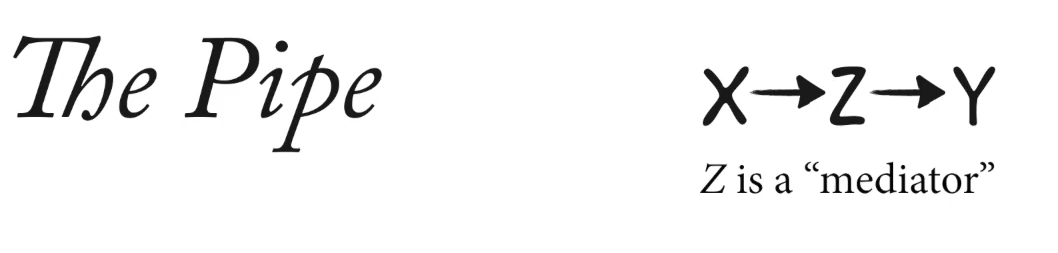
* Z is not a common cause
* Z doesnt influence X at all
* Rather X causes Z and Z causes Y
* No direct causal effect of X on Y
* Y is not independent of X, they are associated
* Once stratified by Z, no association

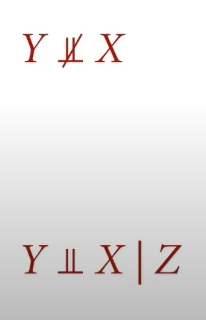

* Statistically The Fork and The Pipe look same, but causally theyre different

## Discrete Example

Below we simulate a "Pipe" generative process:

$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p*) \\
Y &\sim \text{Bernoulli}(q*) \\
p^* &= 0.9 X + 0.1 (1 - X) \\
q^* &= 0.9 Z + 0.1 (1 - Z) \\
\end{align*}
$$

In [14]:
np.random.seed(1234)
n_samples = 1000
X = stats.bernoulli.rvs(p=.5, size=n_samples)

p_star = X * .9 + (1 - X) * .1
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = Z * .9 + (1 - Z) * .1
Y = stats.bernoulli.rvs(p=q_star, size=n_samples)

In [16]:
def summarize_discrete_counfound_simulation(X, Y, Z):
    print(f'Correlation between X and Y: {np.corrcoef(X, Y)[0, 1]:1.2}')
    print("Cross tabulation:")
    print(utils.crosstab(X, Y, labels=['X', 'Y']))
    
    for z in [0, 1]:
        X_z = X[Z==z]
        Y_z = Y[Z==z]
        
        print(f'\nCorrelation between X and Y conditioned on Z={z}: {np.corrcoef(X_z, Y_z)[0, 1]:1.2f}')
        print("Cross tabulation:")
        print(utils.crosstab(X_z, Y_z, labels=['X', 'Y']))

In [17]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: 0.65
Cross tabulation:
     X    Y
X  396   84
Y   89  431

Correlation between X and Y conditioned on Z=0: -0.02
Cross tabulation:
     X   Y
X  392  46
Y   41   4

Correlation between X and Y conditioned on Z=1: -0.01
Cross tabulation:
    X    Y
X   4   38
Y  48  427


#### Continous Example

In [18]:
np.random.seed(1234)
n_samples = 1000

X = stats.norm.rvs(size=n_samples)
p_star = utils.invlogit(X)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

mu_star = 2 * Z - 1
Y = stats.norm.rvs(loc=mu_star, size=n_samples)

pipe_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

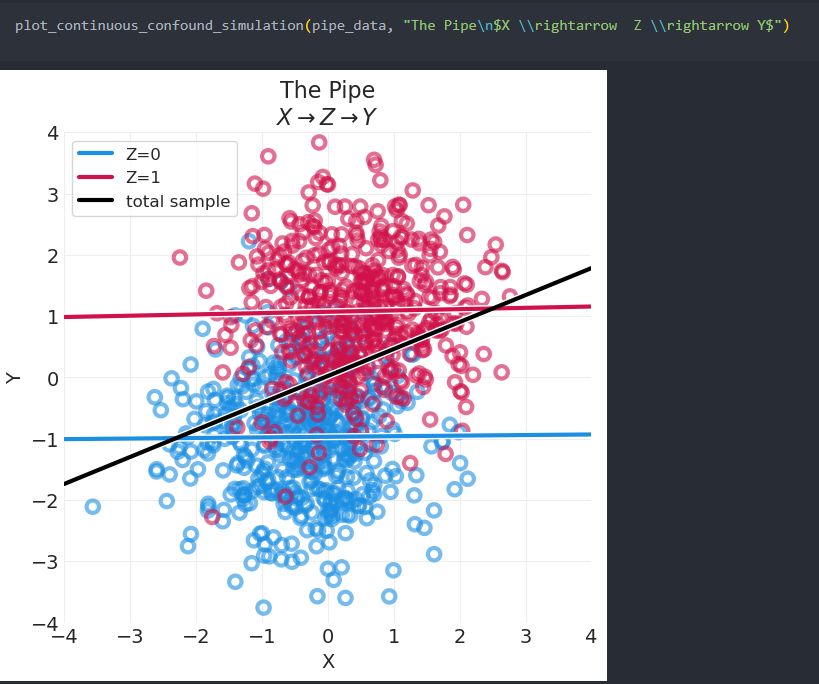

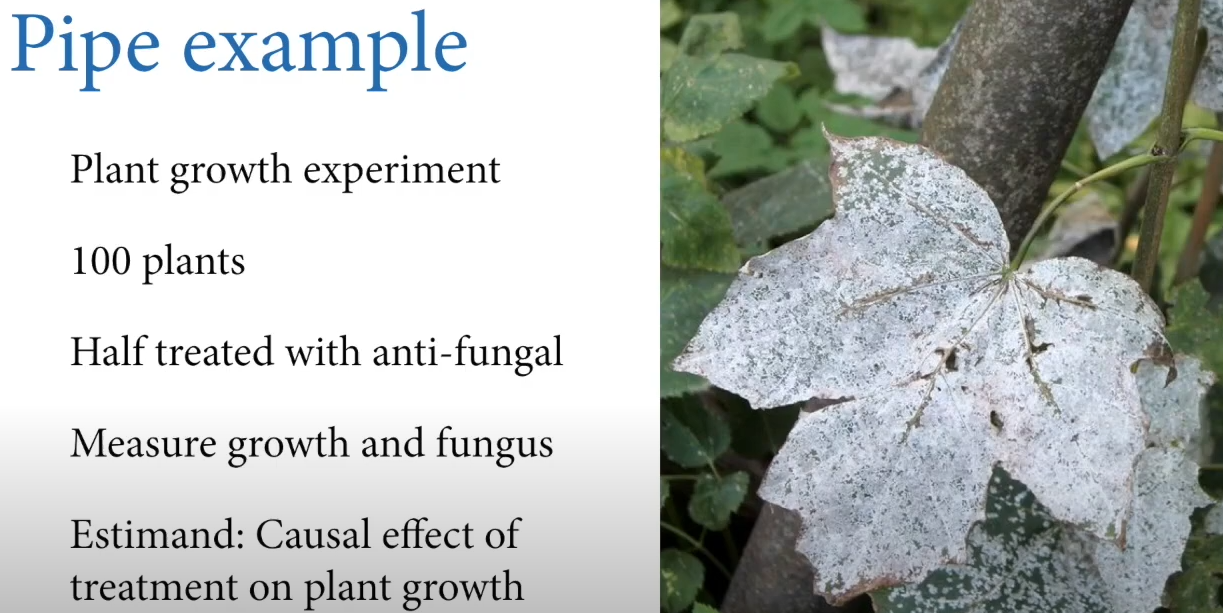

#### Scientific Model
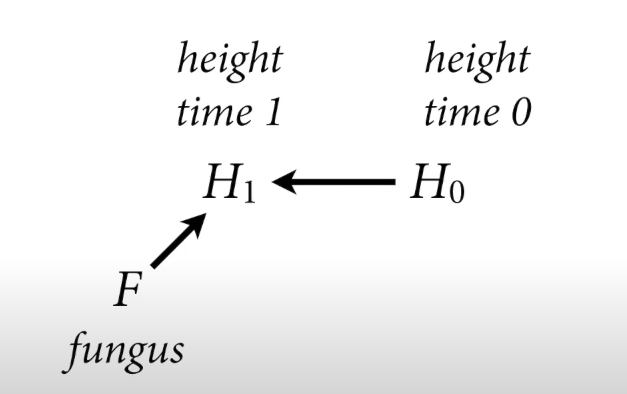

* H_0 - Height time 0 is before starting the experiment
* H_1 - Height after the experiment
* There is a causal influence of H_0 on H_1 because the taller the plant at start, the taller it will be
* And then there's the fungus that affects height at time 1
* And then there's the treatment

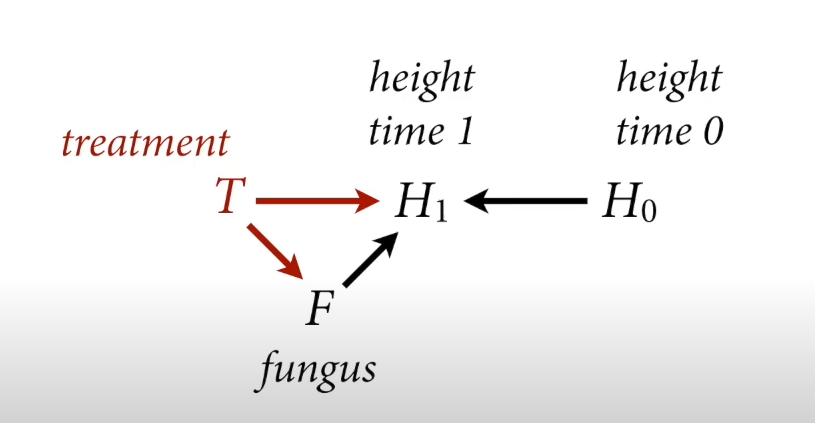

* We want to know the total causal effect of the treatment
    * Estimand: Total causal effect of T
* So path T -> F -> H_1 is a **Pipe**
* Should we stratify by F?
    * No, we should not, we should not put it in the estimator. Why?
        * It would block the pipe
        * It would remove all assocaiation between the treatment and the final height of the plant that was influenced by the fungus
        * In other words it would block all the information about T's effect on H_1 that flow through F
        * So if we were to stratify by F we would only get the direct effect of T on H_1. And that's not what we want, we want the total effect of T on H_1
* This is an example of **post-treatment bias**.
> Rule of Thumb: **consequence of the treatement should not be included in an estimator. (other than the outcome var)**

# THE COLLIDER
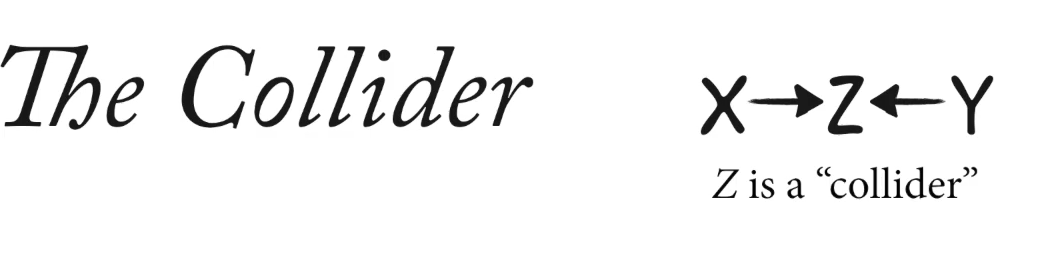
* The collider behaves quite differently than the fork or the pipe
* Tho we still have an X and Y and Z
* The arrows come from X and Y into Z
* Z is jointly caused by X and Y
* X and Y are not associated, they don't share causes
    
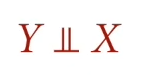
* However, once we stratify by Z, at each level of Z X and Y are **NOT** independent

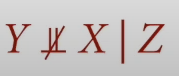

## Discrete Example

Below we simulate a "Collider" generative process:

$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Y &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p*) \\
p^* &= \begin{cases}
    0.9 ,& \text{if } X + Y \gt 0\\
    0.05,              & \text{otherwise}
\end{cases}
\end{align*}
$$

In [20]:
np.random.seed(123)
n_samples = 1000

X = stats.bernoulli.rvs(p=.5, size=n_samples)
Y = stats.bernoulli.rvs(p=.5, size=n_samples)

# p(z | x, y)
p_star = np.where(X + Y > 0, 0.9, 0.05)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

In [21]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: -0.052
Cross tabulation:
     X    Y
X  240  268
Y  258  234

Correlation between X and Y conditioned on Z=0: 0.41
Cross tabulation:
     X   Y
X  229  21
Y   23  22

Correlation between X and Y conditioned on Z=1: -0.49
Cross tabulation:
     X    Y
X   11  247
Y  235  212


* Again its reminded, that the causes are not in the data
    * We might think we are say in The Fork, because of these strong correlations
    * Every elemental cofound scenario could produce similar samples

#### Continous Example
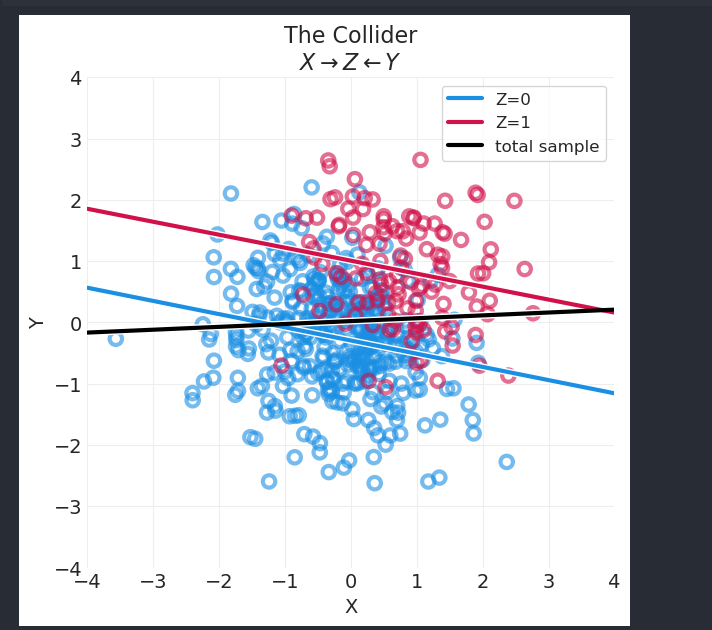

## Collider Example: Grant Awards
* Basically a lot of data in the world can suffer from a type of bias, the post-selection bias (Collider Bias)
* we have Newsworthiness and Trusworthiness that are simulated randomly, not associated with each other

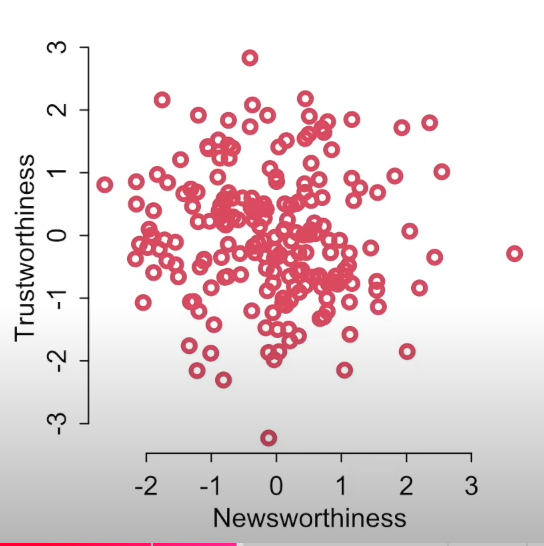
* but once we stratify by whether or not research was funded, we have a negative association between trustworthiness and newsworthiness
    * Thats because research had to score highly on either of these two

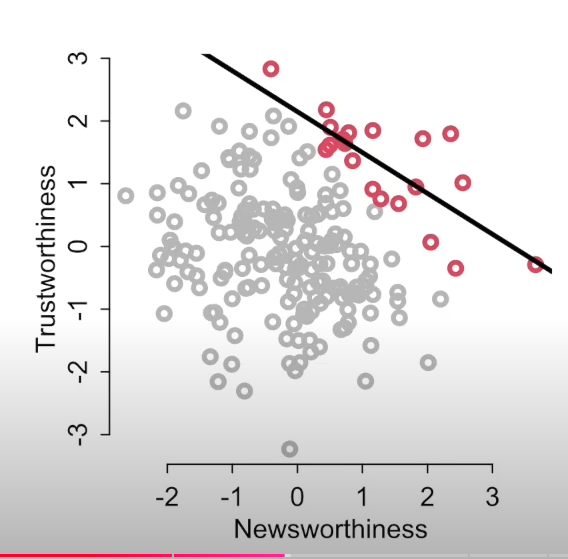

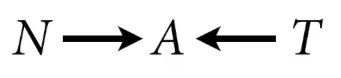


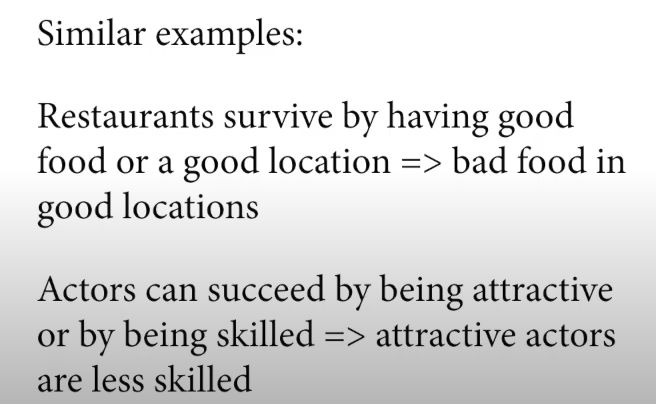

Collider bias can arise through statistical processing
* Endogenous selection: If you stratify by a collider, it creates phantom, non-causal associations

#### EXAMPLE: Influence of Age on Hapiness
* Estimand: Influence of Age on Hapiness
* Possible confound: Marital Status
* Suppose age has zero influence on happiness (for the sake of example)
* But, both age and hapiness influence marital status

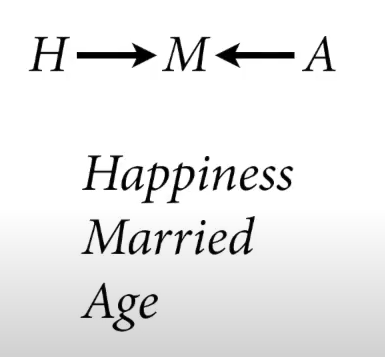

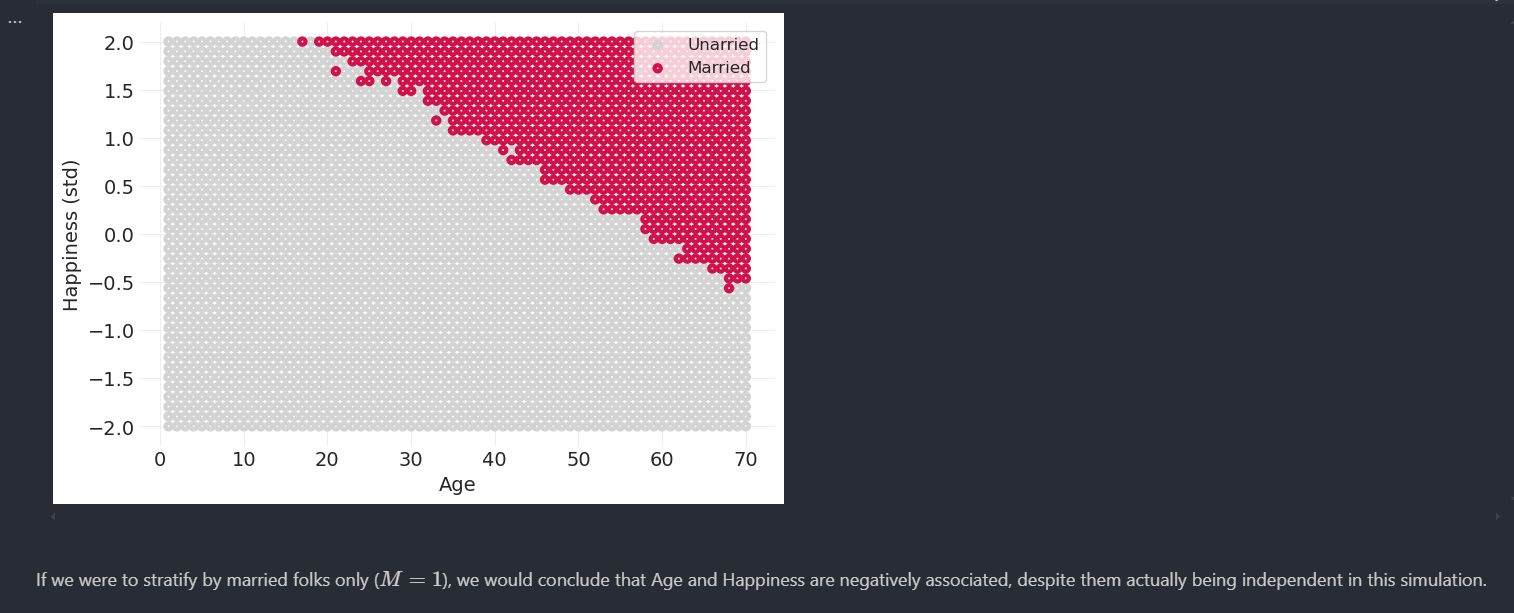

#### THE DESCENDANT

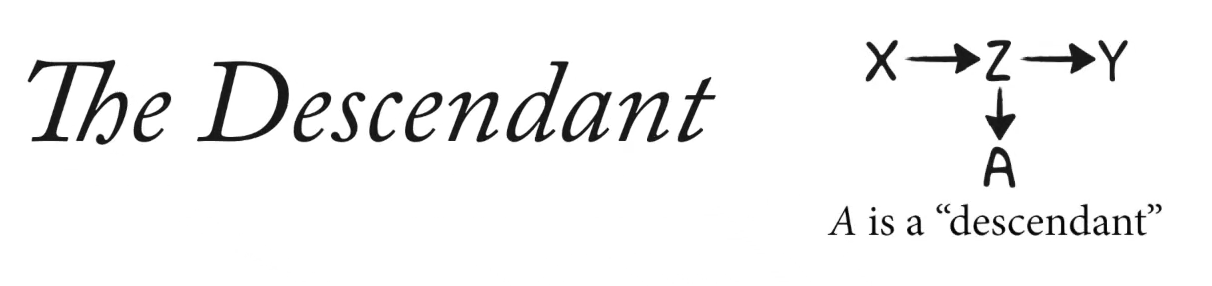

* It can be attached to any type of a confound scenario (Here to the Pipe)

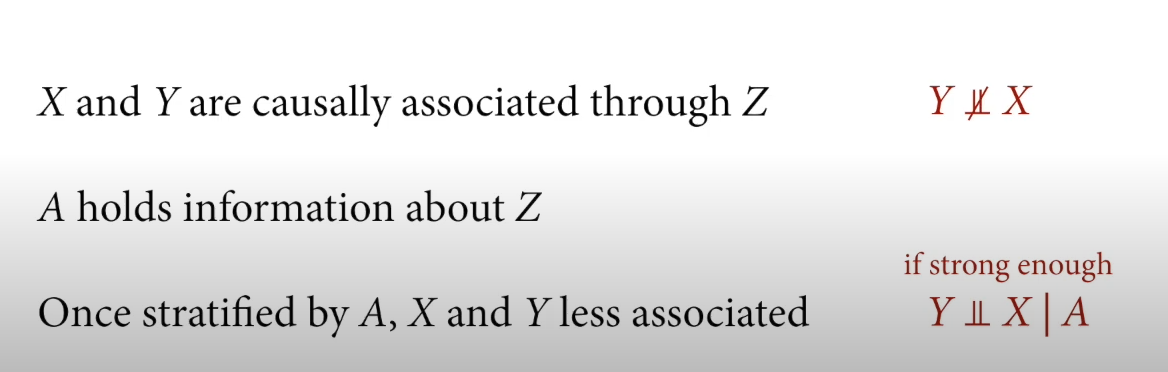

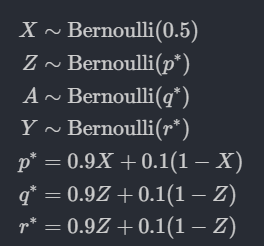

In [22]:
n_samples = 1000

X = stats.bernoulli.rvs(p=.5, size=n_samples)

p_star = .9 * X + .1 * (1 - X)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = .9 * Z + .1 * (1 - Z)
A = stats.bernoulli.rvs(p=q_star, size=n_samples)

r_star = .9 * Z + .1 * (1 - Z)
Y = stats.bernoulli.rvs(p=r_star, size=n_samples)

In [24]:
summarize_discrete_counfound_simulation(X, Y, A)
# Below Z really means A

Correlation between X and Y: 0.63
Cross tabulation:
     X    Y
X  406   87
Y  100  407

Correlation between X and Y conditioned on Z=0: 0.35
Cross tabulation:
     X   Y
X  374  43
Y   52  41

Correlation between X and Y conditioned on Z=1: 0.30
Cross tabulation:
    X    Y
X  32   44
Y  48  366
